In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds

In [3]:
print(tf.__version__)

2.6.0


# 1. data 수집하기
- 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용.
- https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

In [5]:
data = pd.read_csv(os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv')
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


# 2. data 전처리
- 영어 데이터와 비슷한 전처리를 진행한다.
- 내부 단어 토크나이저인 SubwordTextEncoder를 사용하여 전처리

In [6]:
# 사용할 샘플의 최대 개수 파악
MAX_SAMPLES = 11823
print(MAX_SAMPLES)

11823


- 영어 데이터를 처리할 때와 동일하게 공백제거, 특수문자 처리 등 과정을 위한 함수 선언

In [7]:
# 전처리 함수 
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듬
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듬
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r'[^가-힣?.!,]+', ' ', sentence)
    sentence = sentence.strip()
    return sentence

In [8]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
  
    for i in range(len(data)):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(data['Q'][i])) #questions
        outputs.append(preprocess_sentence(data['A'][i])) #answers
       
        if len(inputs) >= MAX_SAMPLES:
            return inputs, outputs
        
    return inputs, outputs

- 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장한다.

In [9]:
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


- SubwordTextEncoder 생성

In [10]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]
8129


- 각 샘플들에 대하여 정수 인코딩 작업을 수행한다.
- 각 샘플들의 최대 허용 길이 지정을 위하여 임의의 샘플에 대하여 정수 인코딩 작업 수행.

In [12]:
print('정수 인코딩 후의 31번째 질문 샘플: {}'.format(tokenizer.encode(questions[30])))
print('정수 인코딩 후의 31번째 답변 샘플: {}'.format(tokenizer.encode(answers[30])))

정수 인코딩 후의 30번째 질문 샘플: [7846, 172, 546, 37]
정수 인코딩 후의 30번째 답변 샘플: [1918, 5318, 6393, 7903, 70, 2072, 1202, 1]


In [13]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

- 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩 함수 선언

In [14]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [15]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장 크기 :',(VOCAB_SIZE))
print('필터링 후 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후 답변 샘플 개수: {}'.format(len(answers)))

단어장 크기 : 8129
필터링 후 질문 샘플 개수: 11823
필터링 후 답변 샘플 개수: 11823


- 필터링 후 샘플의 개수와 단어장 크기의 변화는 없었다.

In [16]:
# Teacher forcing을 위한 tfds 설정
BATCH_SIZE = 128
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 3. 모델 구성하기
- 트렌스포머 모델을 구현해본다.
- 모델 구현을 위한 트렌스포머 모델의 각 레이어를 먼저 구현한다.

## 3.1 PositionalEncoding
- 입력과 출력을 임베딩

In [24]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        # 결과 값의 범위를 -1~1 범위로 축소시켜준다. 
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

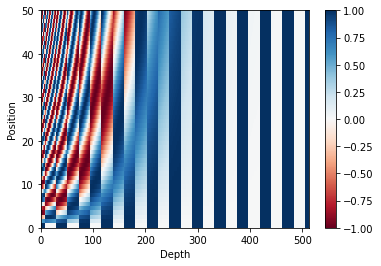

In [25]:
# 임베딩 차원이 512이고 최대 문장 길이가 50인 포지셔널 인코딩 행렬 표현
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 3.2 scaled dot product attention
- 어텐션 값을 구하는 함수
- 출력값이 작아지는 것을 방지하기 위하여 스케일링 필요.

In [26]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

## 3.3 MultiHeadAttention
- 기존 어텐션과 다르게 num_heads 만큼 나누어서 어텐션을 수행하고 다시 하나로 concat

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        # 해드 수
        self.num_heads = num_heads
        # 임베딩 벡터 차원수
        self.d_model = d_model

        # 나누어 떨어지지않으면 문제 생길 수 있어서 예외 처리
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

## 3.4 masking
- Padding token을 이용

In [28]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [29]:
# 룩 어헤드 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

## 3.5 Encoder layer
- 인코더 레이어 하나를 함수로 구현.

In [30]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    # 셀프 어텐션을 멀티해드로 대체함; for 병렬처리
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units*4, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [31]:
def encoder(vocab_size,
            units,
            d_model,
            num_heads,
            dropout,
            num_layers=6,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # LayerNormalization 추가
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 3.6 decoder  layer
- 디코더 레이어를 함수로 구현

In [32]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [33]:
def decoder(vocab_size,
            units,
            d_model,
            num_heads,
            dropout,
            num_layers=6,  # 기본값이 없는 인자로 변경
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## 3.7 transformer 모델 구현
- 구현한 레이어를 바탕으로 transformer 모델을 구현한다.

In [34]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용
    # 내부적으로 패딩 마스크도 포함
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

- 모델 생성

In [35]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4711680     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

- 손실함수로 SparseCategoricalCrossentropy 를 사용

In [36]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

- 학습 진행도에 따라서 학습률을 설정해준다.

In [37]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

- 모델 compile

In [38]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [39]:
EPOCHS = 100
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
93/93 [==============================] - 29s 104ms/step - loss: 1.5144 - accuracy: 0.0170
Epoch 2/100
93/93 [==============================] - 10s 104ms/step - loss: 1.3804 - accuracy: 0.0438
Epoch 3/100
93/93 [==============================] - 10s 105ms/step - loss: 1.2311 - accuracy: 0.0493
Epoch 4/100
93/93 [==============================] - 10s 106ms/step - loss: 1.1000 - accuracy: 0.0499
Epoch 5/100
93/93 [==============================] - 10s 106ms/step - loss: 1.0074 - accuracy: 0.0504
Epoch 6/100
93/93 [==============================] - 10s 107ms/step - loss: 0.9494 - accuracy: 0.0528
Epoch 7/100
93/93 [==============================] - 10s 108ms/step - loss: 0.9055 - accuracy: 0.0554
Epoch 8/100
93/93 [==============================] - 10s 108ms/step - loss: 0.8645 - accuracy: 0.0576
Epoch 9/100
93/93 [==============================] - 10s 108ms/step - loss: 0.8231 - accuracy: 0.0605
Epoch 10/100
93/93 [==============================] - 10s 107ms/step - loss: 0.779

# 4. 모델 평가하기
- loss 와 accuracy 그래프를 출력하여 확인해본다.

- loss

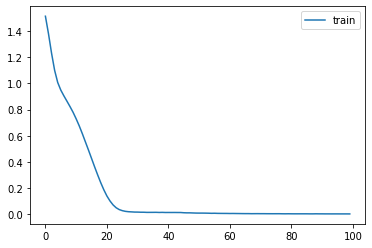

In [40]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

- accuracy

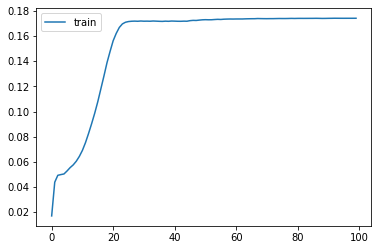

In [41]:
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.show()

- Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만들어본다.
- 학습시킨 트랜스포머 모델을 사용하여 입력한 문장을 인코딩하고 디코딩하는 과정을 수행하는 함수

In [44]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
              break

        # 예측한 단어들은 지속적으로 output_sequence에 추가
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

- 예측된 문장을 생성하여 출력

In [45]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [46]:
sentence_generation('오늘 뭐해요?')

입력 : 오늘 뭐해요?
출력 : 저도 좀 알려주세요 .


'저도 좀 알려주세요 .'

In [47]:
sentence_generation('오늘 뭐해요')

입력 : 오늘 뭐해요
출력 : 저도 좀 알려주세요 .


'저도 좀 알려주세요 .'

In [48]:
sentence_generation('오늘 바빠요')

입력 : 오늘 바빠요
출력 : 하나씩 하세요 .


'하나씩 하세요 .'

In [49]:
sentence_generation('오늘 바빠요?')

입력 : 오늘 바빠요?
출력 : 하나씩 하세요 .


'하나씩 하세요 .'

In [50]:
sentence_generation('오늘 왜그래')

입력 : 오늘 왜그래
출력 : 자신에게 물어보세요 .


'자신에게 물어보세요 .'

In [51]:
sentence_generation('오늘 왜그래?')

입력 : 오늘 왜그래?
출력 : 자신에게 물어보세요 .


'자신에게 물어보세요 .'

In [54]:
sentence_generation('공부하기 싫어')

입력 : 공부하기 싫어
출력 : 잠시 쉬어도 돼요 .


'잠시 쉬어도 돼요 .'

In [55]:
sentence_generation('공부하기 싫어?')

입력 : 공부하기 싫어?
출력 : 잠시 쉬어도 돼요 .


'잠시 쉬어도 돼요 .'

- 평서문과 전처리와 토큰화 과정에서 특수문자를 생략했으므로 질문과 평서문에 대한 구분이 불가능하다는 것을 알 수 있었다.
    - 질문형 문장과 평서문 모두 동일한 대답을 출력했다.

In [57]:
sentence_generation('피씨방 갈래')

입력 : 피씨방 갈래
출력 : 말해보세요 .


'말해보세요 .'

In [58]:
sentence_generation('어떤 게임 좋아해')

입력 : 어떤 게임 좋아해
출력 : 마음이 따뜻할 것 같아요 .


'마음이 따뜻할 것 같아요 .'

In [59]:
sentence_generation('아이펠')

입력 : 아이펠
출력 : 많이 힘든가봅니다 .


'많이 힘든가봅니다 .'

- 외래어, 지엽적인 단어들이 포함되는 문장에서 다소 엉뚱한 답변을 하는 경향이 보였다.

In [65]:
sentence_generation('놀러가고 싶다')

입력 : 놀러가고 싶다
출력 : 탁 트인 바다 좋죠 !


'탁 트인 바다 좋죠 !'

In [67]:
sentence_generation('면접 탈락했어')

입력 : 면접 탈락했어
출력 : 회사와 자신에 대해서 더 공부해서 자신감을 가져보세요 .


'회사와 자신에 대해서 더 공부해서 자신감을 가져보세요 .'

In [68]:
sentence_generation('공부 잘하고싶어')

입력 : 공부 잘하고싶어
출력 : 지금도 충분히 잘하고 있어요 .


'지금도 충분히 잘하고 있어요 .'

In [69]:
sentence_generation('피곤해')

입력 : 피곤해
출력 : 그 사람을 위해 에너지를 쓰니까요 .


'그 사람을 위해 에너지를 쓰니까요 .'

In [77]:
sentence_generation('짜증나')

입력 : 짜증나
출력 : 짜증날 때는 기분 푸는 음악 어때요 ?


'짜증날 때는 기분 푸는 음악 어때요 ?'

- 평서문에서는 실제 대화를 하는 듯한 답변을 내 놓았다.

# 5. 회고

- 평서문에서는 실제 대화를 하는 듯한 답변을 내 놓았다.
- 평서문과 전처리와 토큰화 과정에서 특수문자를 생략했으므로 질문과 평서문에 대한 구분이 불가능하다는 것을 알 수 있었다.
    - 질문형 문장과 평서문 모두 동일한 대답을 출력했다.
- 외래어, 지엽적인 단어들이 포함되는 문장에서 다소 엉뚱한 답변을 하는 경향이 보였다.
- loss 와 accuracy 결과로만 보았을 때, 학습이 순조롭게 잘 되었다고 판단하였지만 실제 출력결과를 보았을 때 논리적으로 맞지 않는 답변이 나타났음을 확인했다.
    - 이 문제는 여러가지 요인들로 인하여 발생할 수 있다.
    - 1. 데이터의 품질과 양이 요인이 될 수 있다. 데이터가 충분하지 않은 경우, 논리적으로 오류가 있거나 잘못된 정보가 포함되어 있을 경우 위와 같은 문제들이 발생할 수 있다. 본 예시에서는 데이터의 양이 충분하지 않은 것으로 예측해볼 수 있다.
    - 2. 모델이 학습중에 보지 못한 단어나 구문에 대한 적절한 처리가 이루어지지는 않았다.